# Homework Answers
Here are some answers to the homework problem sets.  There are many different ways to solve each of these.  Here are one potential way to solve the problem

In [217]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import regress, zscore, fdr, one_sample_permutation, find_spikes
from nltools.external import glover_hrf
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from sklearn.metrics import pairwise_distances
from scipy.stats import binom, ttest_1samp
import networkx as nx
from numpy import sin, pi, arange
from numpy.fft import fft, ifft
from scipy.signal import butter, filtfilt, freqz

netid = 'f00275v'
base_dir = '/dartfs/rc/lab/P/Psych60/'
base_dir = '/Volumes/Psych60/'
output_dir = os.path.join(base_dir, 'students_output', netid)
data_dir = os.path.join(base_dir, 'data','brainomics_data')

# 1 Intro to Programming

## Find Even Numbers
Let’s say I give you a list saved in a variable: a = [1, 4, 9, 16, 25, 36, 49, 64, 81, 100]. Make a new list that has only the even elements of this list in it.

In [195]:
a = [1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

b = [bool(1-x%2) for x in a]

c = []
for x in a:
    if not x%2:
        c.append(x)
        
def evens_only(seq):
    return [n for n in seq if n%2 == 0]

evens_only(a)


TypeError: list indices must be integers or slices, not list

## Find Maximal Range
Given an array length 1 or more of ints, return the difference between the largest and smallest values in the array. 

In [196]:
a = np.random.randint(0,100, 10)
max(a)-min(a)

61

## Duplicated Numbers
Find the numbers in list a that are also in list b

a = [0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361]

b = [0, 4, 16, 36, 64, 100, 144, 196, 256, 324]

In [197]:
a = [0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361]

b = [0, 4, 16, 36, 64, 100, 144, 196, 256, 324]

print(set(a) & set(b))

print([x for x in a if x in b])

{0, 256, 64, 4, 36, 100, 196, 324, 16, 144}
[0, 4, 16, 36, 64, 100, 144, 196, 256, 324]


## Speeding Ticket Fine
You are driving a little too fast on the highway, and a police officer stops you. Write a function that takes the speed as an input and returns the fine.


If speed is 60 or less, the result is `$0`. If speed is between 61 and 80 inclusive, the result is `$100`. If speed is 81 or more, the result is `$500`. 

In [198]:
def speeding_ticket(speed):
    if speed <= 60:
        return '$0'
    elif (speed >=61) & (speed < 100):
        return '$100'
    else:
        return ('$500')
speeding_ticket(81)

'$100'

# 5 Signal Processing

In [219]:
def rad_sample_to_hz(x, fs):
    return (x*fs)/(2*np.pi)

def plot_filter(b, a, fs):
    plt.figure(figsize=(20,5))
    w, h = freqz(b, a, worN=512*2, whole=False)
    plt.plot(rad_sample_to_hz(w, fs), abs(h), linewidth=3)
    plt.ylabel('Gain', fontsize=18)
    plt.xlabel('Frequency', fontsize=18)

## Create a simulated time series with 7 different frequencies with noise

Text(0.5, 0, 'Time')

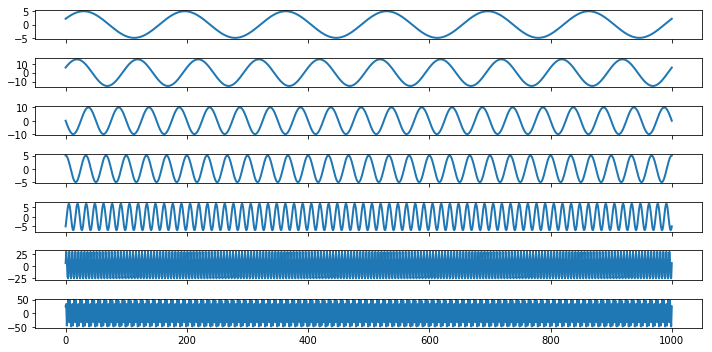

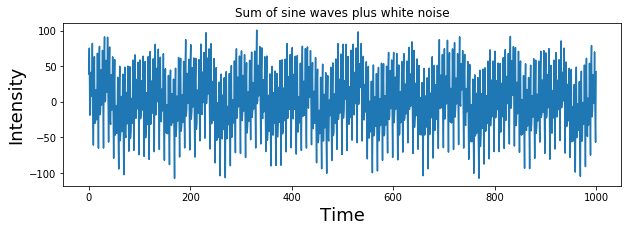

In [205]:
sampling_freq = 500

freq = [3, 5, 10, 15, 35, 100, 150]
amplitude = [5, 15, 10, 5, 7, 30, 50]
phases = pi*np.array([1/7, 1/8, 1, 1/2, -1/4, 1/16, 1/6])

time = arange(-1, 1 + 1/sampling_freq, 1/sampling_freq) 

sine_waves = []
for i,f in enumerate(freq):
    sine_waves.append(amplitude[i] * sin(2*pi*f*time + phases[i]))
sine_waves = np.array(sine_waves)


f,a = plt.subplots(nrows=len(freq), ncols=1, figsize=(10,5), sharex=True)
for i,x in enumerate(freq):
    a[i].plot(sine_waves[i,:], linewidth=2)
plt.tight_layout()    

noise = 5 * np.random.randn(sine_waves.shape[1])
signal = np.sum(sine_waves,axis=0) + noise

plt.figure(figsize=(10,3))
plt.plot( signal )
plt.title("Sum of sine waves plus white noise")
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

## Show that you can identify each signal using a FFT


Text(0, 0.5, 'Frequency (Hz)')

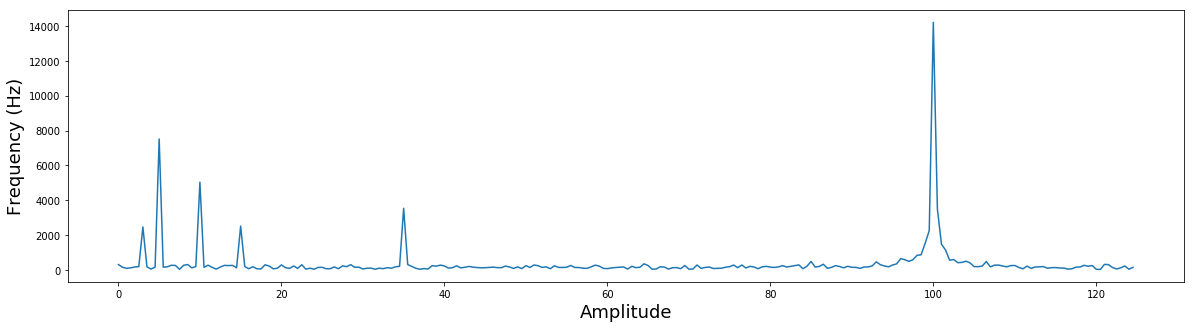

In [210]:
fourier_fft = fft(signal)

plt.figure(figsize=(20,5))
plt.plot((np.arange(0,250)/2), np.abs(fourier_fft[0:250]))
plt.xlabel('Amplitude', fontsize=18)
plt.ylabel('Frequency (Hz)', fontsize=18)

## Remove one frequency with a bandstop filter


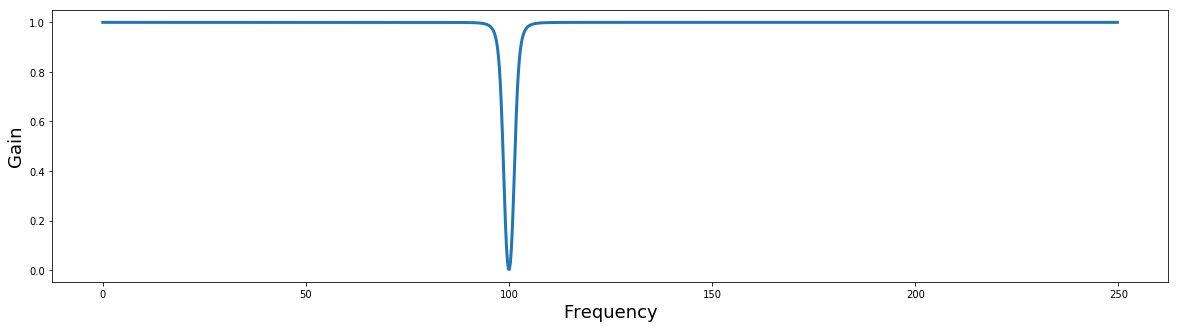

In [221]:
filter_order = 2 
lowcut = 98
highcut = 102

# Create the filter
b,a = butter(filter_order, [lowcut, highcut], btype='bandstop', output='ba', fs=sampling_freq)

# Plot the filter
plot_filter(b, a, sampling_freq)

# Apply the filter
filtered = filtfilt(b, a, signal)


## Reconstruct the signal with the frequency removed and compare it to the original

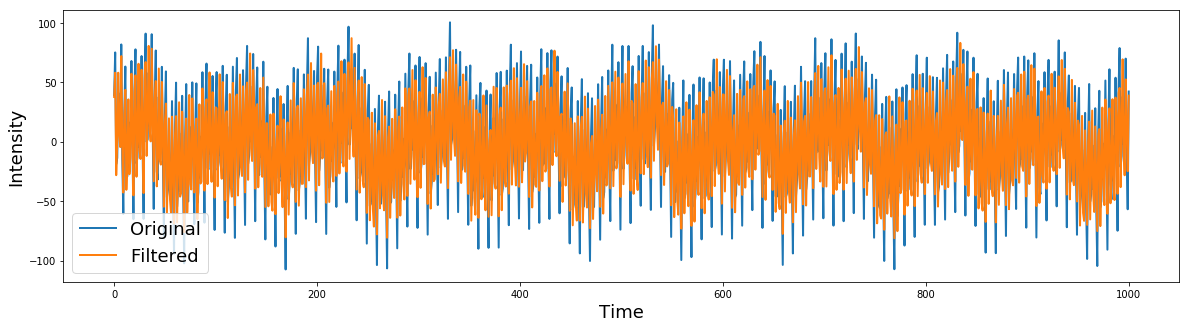

In [222]:
plt.figure(figsize=(20,5))
plt.plot(signal, linewidth=2)
plt.plot(filtered, linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

# 9 GLM

In [10]:
def estimate_beta(X, Y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)

def plot_timeseries(data, linewidth=3, labels=None):
    plt.figure(figsize=(20,5))
    plt.plot(data, linewidth=linewidth)
    plt.ylabel('Intensity', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    plt.tight_layout()
    if labels is not None:
        plt.legend(labels, fontsize=18)
        
def r_square(Y, predicted_y):
    SS_total = np.sum((Y - np.mean(Y))**2)
    SS_residual = np.sum((Y - predicted_y)**2)
    return 1-(SS_residual/SS_total)

def contrast_efficiency(X, contrast):
    c = np.array(contrast)
    return 1/(np.dot(np.dot(c, np.linalg.pinv(np.dot(X.T, X))), c.T))

## 1. What happens when we vary the signal amplitude?

Some signals will be very strong and others weaker. How does the contrast efficiency change when the signal amplitudes are stronger and weaker?

In this exercise, make a plot showing how the contrast efficiency changes over 3 different levels of signal intensity.

Text(0.5, 0, 'Signal Intensity')

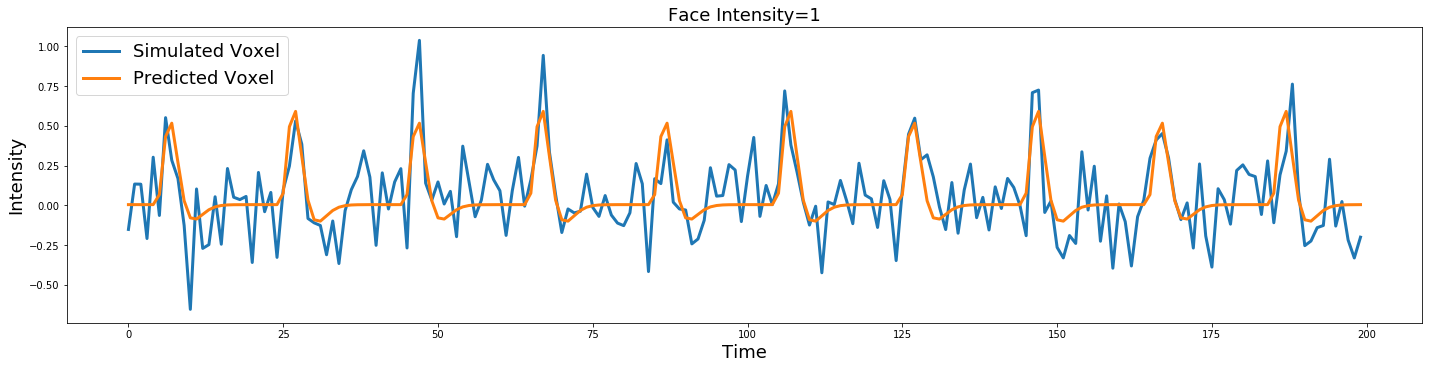

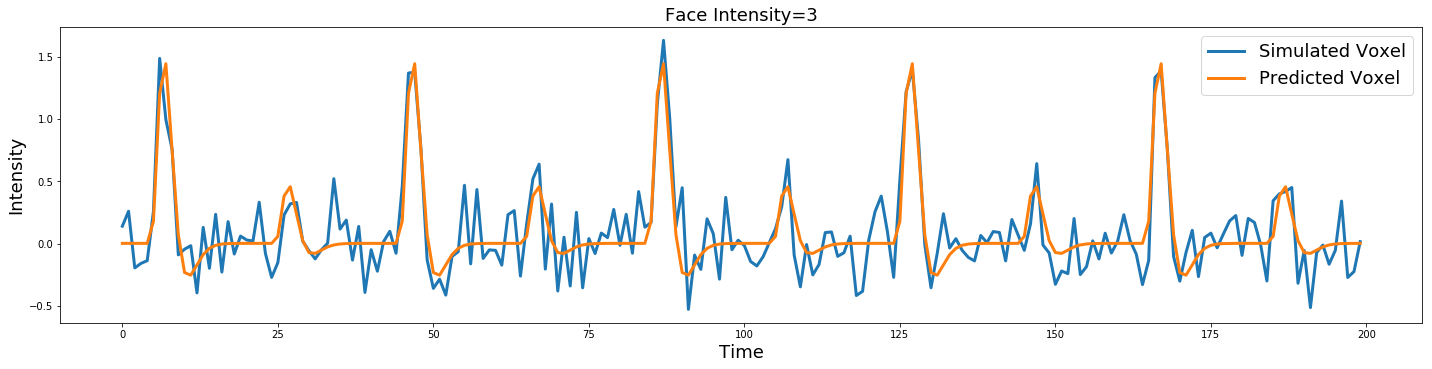

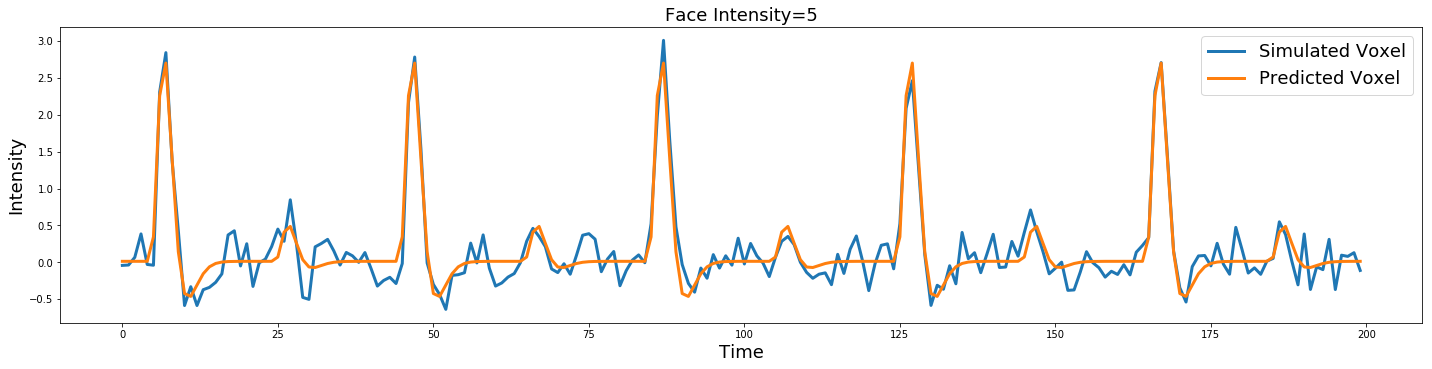

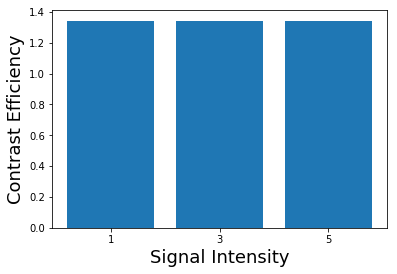

In [29]:
# Set Simulation Parameters
n_tr = 200
n_trial = 5
tr = 2
face_intensity = 2
object_intensity = 1
sigma = 0.15
hrf = glover_hrf(tr, oversampling=1)

# Build Simulation
face_trials = np.arange(10, n_tr, int(n_tr/n_trial))
obj_trials = np.arange(30, n_tr, int(n_tr/n_trial))

face = np.zeros(n_tr)
face[face_trials] = 1
obj = np.zeros(n_tr)
obj[obj_trials] = 1

# Estimate Contrast Efficiency
results = []
for face_intensity in [1, 3, 5]:
    voxel_conv = np.vstack([np.convolve(face*face_intensity, hrf, mode='same'), np.convolve(obj*object_intensity, hrf, mode='same')]).T
    epsilon = sigma*np.random.randn(n_tr, 2)
    voxel_conv_noise = voxel_conv + epsilon

    # Build Model
    Y = voxel_conv_noise.sum(axis=1)
    X = np.vstack([np.ones(len(face)), np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T

    # Estimate Model
    beta = estimate_beta(X, Y)
    predicted_y = np.dot(X, beta)
    residual = Y - predicted_y
    predicted_sigma = np.std(residual)
    predicted_ts = np.vstack([Y, predicted_y]).T
    
    c1 = [0, 1, 0]
    c3 = [0, 1, -1]

    results.append(contrast_efficiency(X, c3))
    
    plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])
    plt.title(f"Face Intensity={face_intensity}", fontsize=18)

plt.figure()
plt.bar(['1','3','5'], results)
plt.ylabel('Contrast Efficiency', fontsize=18)
plt.xlabel('Signal Intensity', fontsize=18)

## 2. What happens when we vary the noise?

How does the amount of noise in the data impact our contrast efficiency?  

In this exercise, make a plot showing the contrast efficiency for 3 different levels of simulated noise.

Text(0.5, 0, 'Signal Intensity')

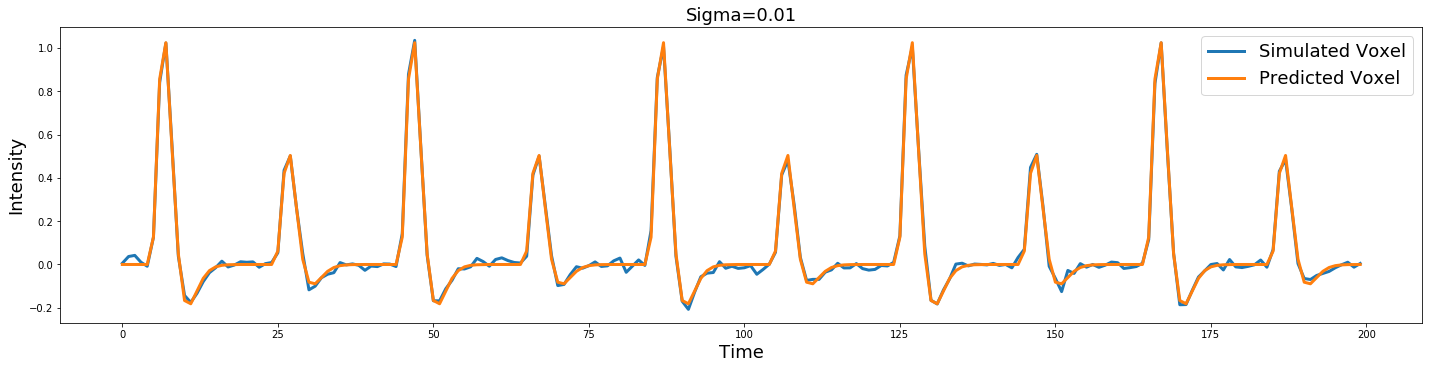

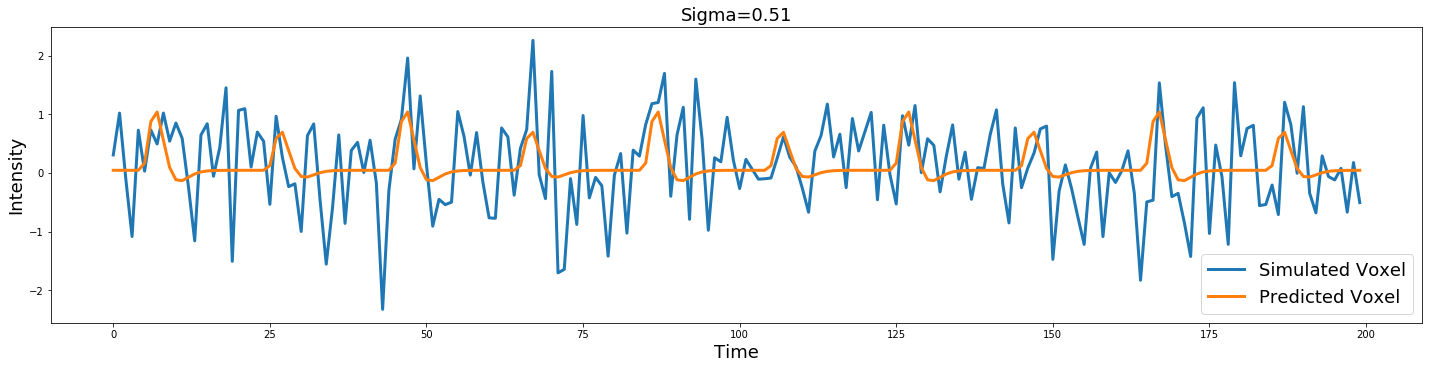

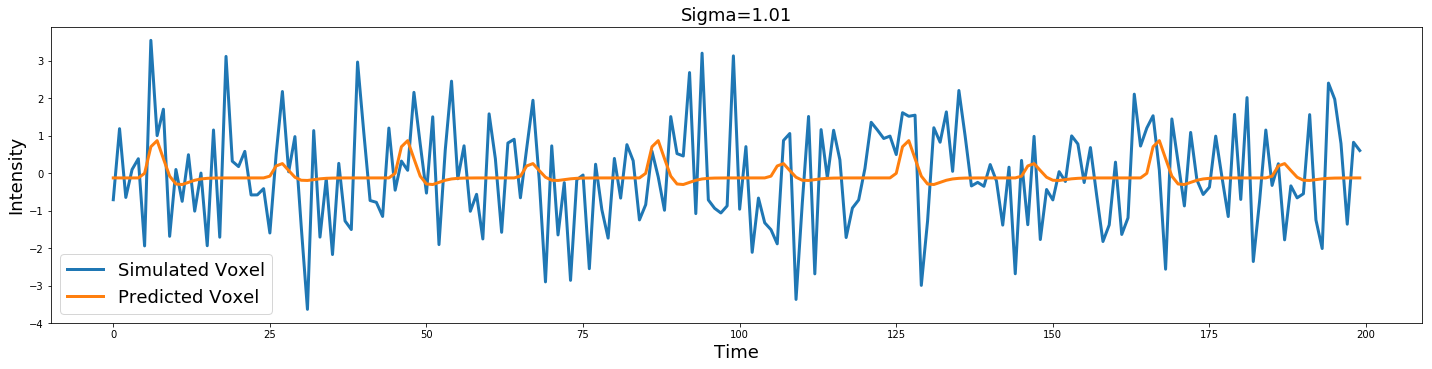

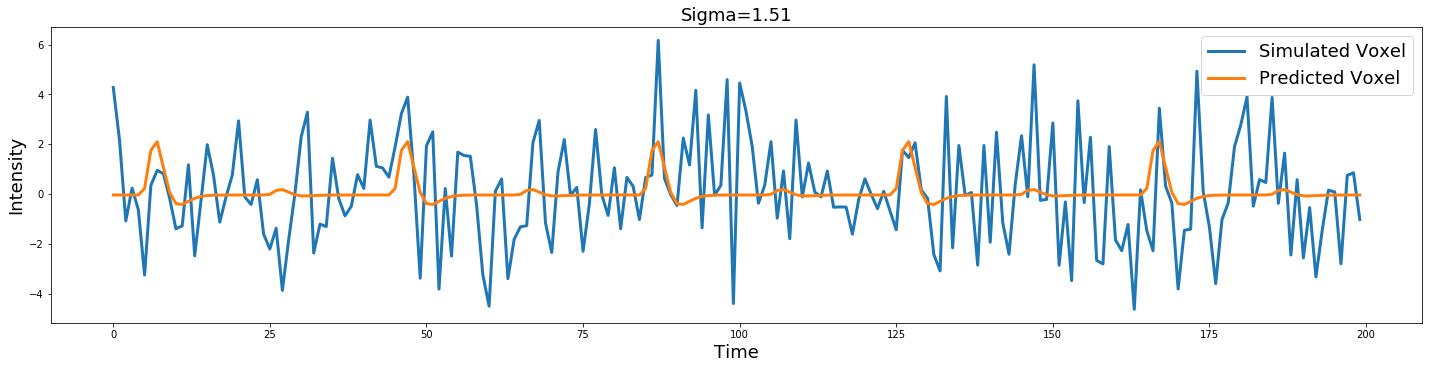

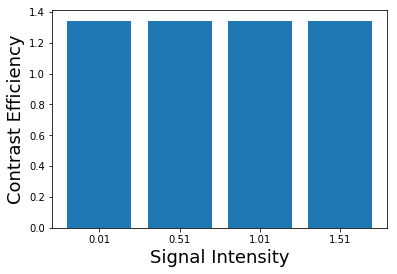

In [28]:
# Set Simulation Parameters
n_tr = 200
n_trial = 5
tr = 2
face_intensity = 2
object_intensity = 1
sigma = 0.15
hrf = glover_hrf(tr, oversampling=1)

# Build Simulation
face_trials = np.arange(10, n_tr, int(n_tr/n_trial))
obj_trials = np.arange(30, n_tr, int(n_tr/n_trial))

face = np.zeros(n_tr)
face[face_trials] = 1
obj = np.zeros(n_tr)
obj[obj_trials] = 1
# plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])

# Estimate Contrast Efficiency
results = []
for sigma in np.arange(0.01, 2, .5):
    voxel_conv = np.vstack([np.convolve(face*face_intensity, hrf, mode='same'), np.convolve(obj*object_intensity, hrf, mode='same')]).T
    epsilon = sigma*np.random.randn(n_tr, 2)
    voxel_conv_noise = voxel_conv + epsilon

    # Build Model
    Y = voxel_conv_noise.sum(axis=1)
    X = np.vstack([np.ones(len(face)), np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T

    # Estimate Model
    beta = estimate_beta(X, Y)
    predicted_y = np.dot(X, beta)
    residual = Y - predicted_y
    predicted_sigma = np.std(residual)
    predicted_ts = np.vstack([Y, predicted_y]).T
    
    c1 = [0, 1, 0]
    c3 = [0, 1, -1]
    
    results.append(contrast_efficiency(X, c3))
    plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])
    plt.title(f"Sigma={sigma}", fontsize=18)

plt.figure()
plt.bar([str(x) for x in np.arange(0.01, 2, .5)], results)
plt.ylabel('Contrast Efficiency', fontsize=18)
plt.xlabel('Signal Intensity', fontsize=18)

## 3. How many trials do we need?

A common question in experimental design is determining the optimal number of trials.

In this exercise, try evaluating how 3 different numbers of trials might impact the contrast efficiency.

Text(0.5, 0, 'N Trials')

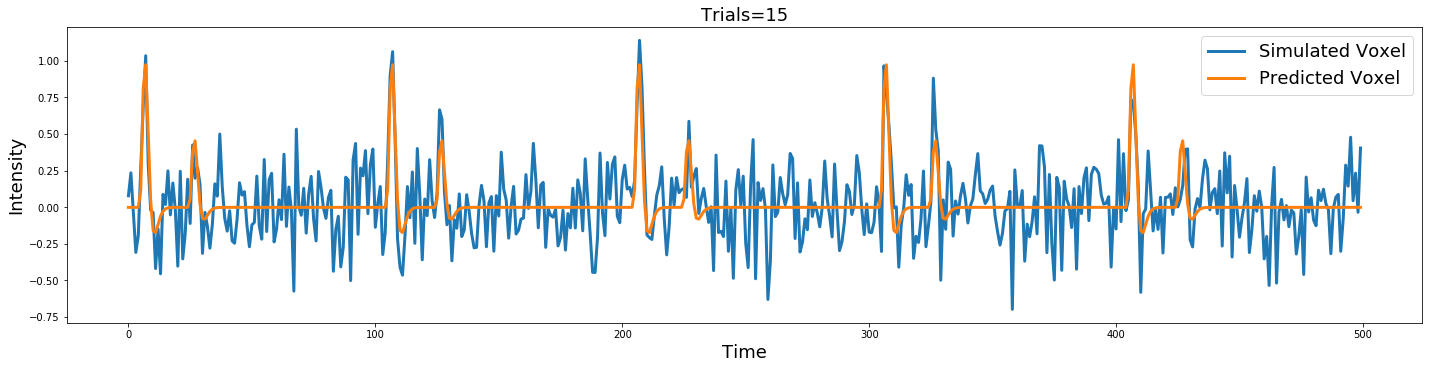

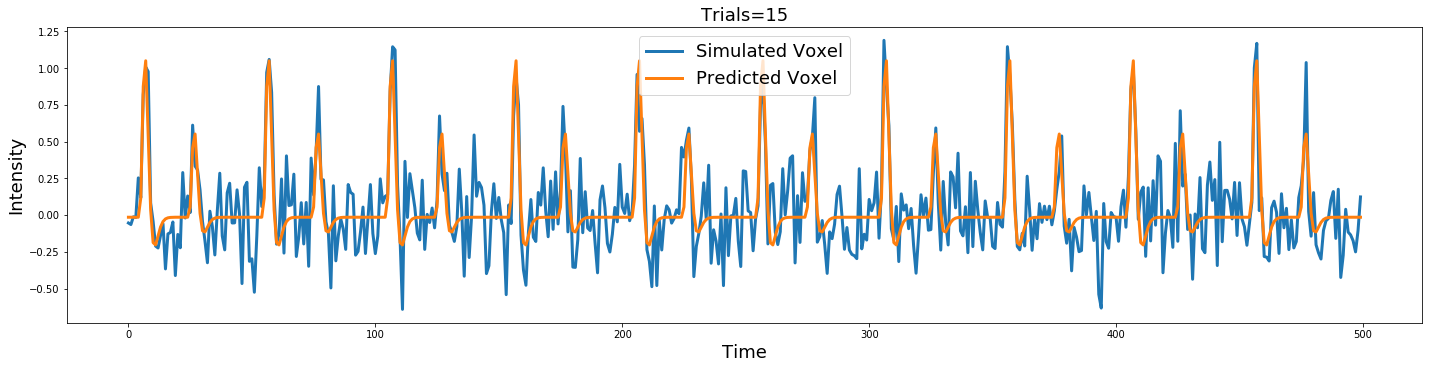

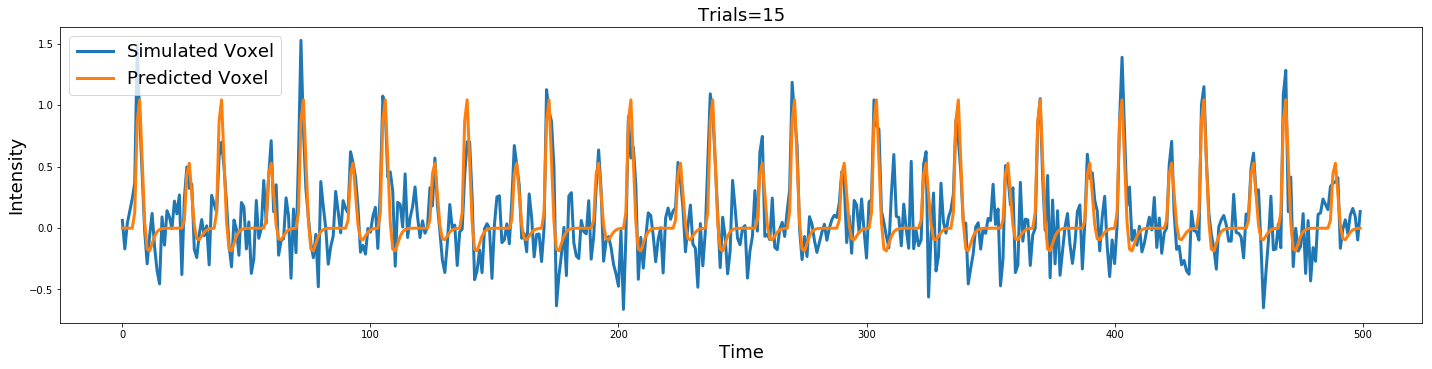

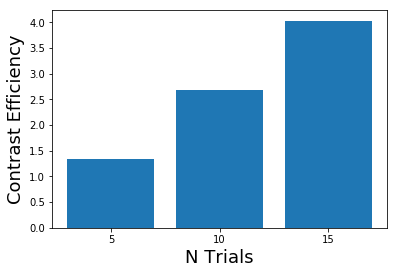

In [34]:
# Set Simulation Parameters
n_tr = 500
tr = 2
face_intensity = 2
object_intensity = 1
sigma = 0.15
hrf = glover_hrf(tr, oversampling=1)

# Estimate Contrast Efficiency
results = []
for n_trial in [5, 10, 15]:
    # Build Simulation
    face_trials = np.arange(10, n_tr, int(n_tr/n_trial))
    obj_trials = np.arange(30, n_tr, int(n_tr/n_trial))

    face = np.zeros(n_tr)
    face[face_trials] = 1
    obj = np.zeros(n_tr)
    obj[obj_trials] = 1

    voxel_conv = np.vstack([np.convolve(face*face_intensity, hrf, mode='same'), np.convolve(obj*object_intensity, hrf, mode='same')]).T
    epsilon = sigma*np.random.randn(n_tr, 2)
    voxel_conv_noise = voxel_conv + epsilon

    # Build Model
    Y = voxel_conv_noise.sum(axis=1)
    X = np.vstack([np.ones(len(face)), np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T

    # Estimate Model
    beta = estimate_beta(X, Y)
    predicted_y = np.dot(X, beta)
    residual = Y - predicted_y
    predicted_sigma = np.std(residual)
    predicted_ts = np.vstack([Y, predicted_y]).T
    
    c1 = [0, 1, 0]
    c3 = [0, 1, -1]
    
    results.append(contrast_efficiency(X, c3))
    plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])
    plt.title(f"Trials={n_trials}", fontsize=18)

plt.figure()
plt.bar([str(x) for x in [5, 10, 15]], results)
plt.ylabel('Contrast Efficiency', fontsize=18)
plt.xlabel('N Trials', fontsize=18)

## 4. What is the impact of the stimulus duration?

What if one condition simply results in processes that systematically take longer than the other condition?

In this exercise, let's try to answer this question by creating a simulation where the signal intensity between the two condition is identical, but one simply has a longer duration (i.e., the duration has more TRs than the other condition). 

Make a plot showing what happens to the $\beta$ estimates.

Text(0.5, 0, 'Regressor')

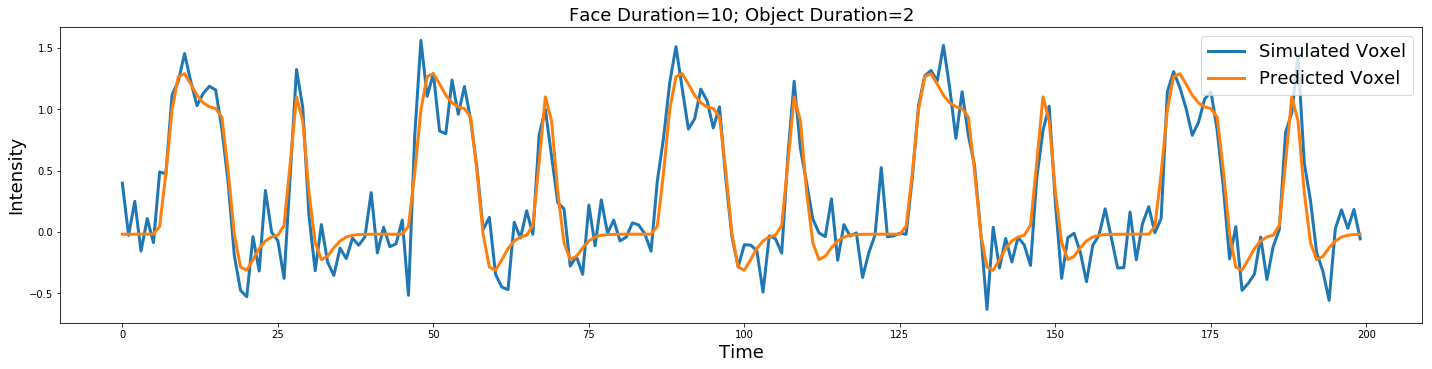

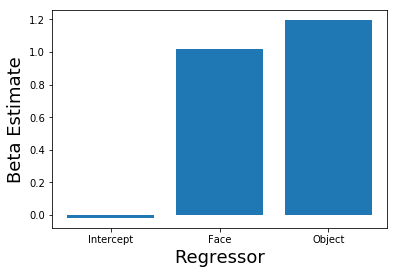

In [77]:
# Set Simulation Parameters
n_tr = 200
n_trial = 5
tr = 2
face_intensity = 1
object_intensity = 1
face_duration = 10
object_duration = 2
sigma = 0.15
hrf = glover_hrf(tr, oversampling=1)

# Build Simulation
face_trials = np.arange(10, n_tr, int(n_tr/n_trial))
obj_trials = np.arange(30, n_tr, int(n_tr/n_trial))

face = np.zeros(n_tr)
face[face_trials] = 1
obj = np.zeros(n_tr)
obj[obj_trials] = 1

face_kernel = np.zeros(face_duration + 2)
face_kernel[1:-1] = 1
obj_kernel = np.zeros(object_duration + 2)
obj_kernel[1:-1] = 1

face = np.convolve(face, face_kernel)[0:n_tr]
obj = np.convolve(obj, obj_kernel)[0:n_tr]

# Estimate Contrast Efficiency
voxel_conv = np.vstack([np.convolve(face*face_intensity, hrf, mode='same'), np.convolve(obj*object_intensity, hrf, mode='same')]).T
epsilon = sigma*np.random.randn(n_tr, 2)
voxel_conv_noise = voxel_conv + epsilon

# Build Model
Y = voxel_conv_noise.sum(axis=1)
X = np.vstack([np.ones(len(face)), np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T

# Estimate Model
beta = estimate_beta(X, Y)
predicted_y = np.dot(X, beta)
residual = Y - predicted_y
predicted_sigma = np.std(residual)
predicted_ts = np.vstack([Y, predicted_y]).T
   
plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])
plt.title(f"Face Duration={face_duration}; Object Duration={object_duration}", fontsize=18)

plt.figure()
plt.bar(['Intercept','Face','Object'], beta)
plt.ylabel('Beta Estimate', fontsize=18)
plt.xlabel('Regressor', fontsize=18)


# GLM Single Subject fMRI

In [112]:
def make_motion_covariates(mc):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

# Load Data
sub = 'S01'
file_name = os.path.join(data_dir, sub ,'preprocessed_fMRI_bold.nii.gz')
data = Brain_Data(file_name)

# Build Design Matrix
tr = 2.4
df = pd.read_csv(os.path.join(data_dir, 'Design_Matrix.csv'))
dm = Design_Matrix(df, sampling_freq=1/tr)
dm_conv = dm.convolve()
dm_conv_filt = dm_conv.add_dct_basis(duration=128)
dm_conv_filt_poly = dm_conv_filt.add_poly(order=2, include_lower=True)
mc = pd.read_csv(os.path.join(data_dir, sub ,'realignment_parameters.txt'), sep='\s', header=None)
mc_cov = make_motion_covariates(mc)
spikes = data.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)
dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, mc_cov, spikes.drop('TR', axis=1)], axis=1)

# Run Regression
data.X = dm_conv_filt_poly_cov
stats = data.regress()

# Extract Only the Task Related Betas (1st 10 regressors)
betas = stats['beta'][0:df.shape[1]]

# Smooth Data
betas = betas.smooth(fwhm=6)

# Write betas to file
homework_name = '10_GLM_Single_Subject_Model'
os.mkdir(os.path.join(output_dir, homework_name))
betas.write(os.path.join(output_dir, homework_name, f'{sub}_localizer_betas.nii.gz'))

# Print Regressor Names
print(df.columns)

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/ipykernel_launcher.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:970: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(np.linalg.pinv(np.dot(X.T, X))))[:, np.newaxis] * sigma[np.newaxis, :]
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/sc

Index(['horizontal_checkerboard', 'motor_left_auditory', 'motor_left_visual',
       'motor_right_auditory', 'motor_right_visual', 'sentence_auditory',
       'sentence_visual', 'subtraction_auditory', 'subtraction_visual',
       'vertical_checkerboard'],
      dtype='object')


## 1. Which regions are more involved with visual compared to auditory sensory processing?
 - Create a contrast to test this hypothesis
 - plot the results
 - write the file to your output folder.

threshold is ignored for simple axial plots


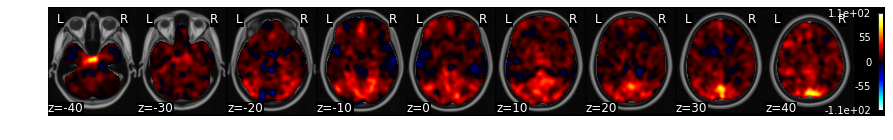

In [109]:
# Include Motor
c1 = [1/6, -1/4, 1/6, -1/4, 1/6, -1/4, 1/6, -1/4, 1/6, 1/6]

# Exclude Motor
c2 = [1/4, 0, 0, 0, 0, -1/2, 1/4, -1/2, 1/4, 1/4]
visual_v_auditory = betas*c2

# Create Plot
f = visual_v_auditory.plot()

# Write to Folder
contrast_name = 'visual_v_auditory'
visual_v_auditory.write(os.path.join(output_dir, homework_name, f'{sub}_{contrast_name}.nii.gz'))

## 2. Which regions are more involved in processing numbers compared to words?
 - Create a contrast to test this hypothesis
 - plot the results
 - write the file to your output folder.

threshold is ignored for simple axial plots


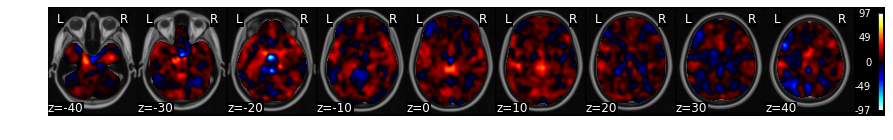

In [110]:
c1 = [0, 0, 0, 0, 0, -1/2, -1/2, 1/2, 1/2, 0]
numbers_v_words = betas*c1

# Create Plot
f = numbers_v_words.plot()

# Write to Folder
contrast_name = 'numbers_v_words'
visual_v_auditory.write(os.path.join(output_dir, homework_name, f'{sub}_{contrast_name}.nii.gz'))

## 3. Which regions are more involved with motor compared to cognitive processes (e.g., language and math)?
 - Create a contrast to test this hypothesis
 - plot the results
 - write the file to your output folder.

threshold is ignored for simple axial plots


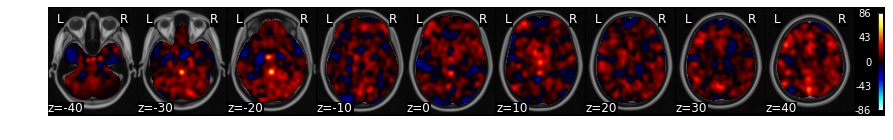

In [111]:
c1 = [0, 1/4, 1/4, 1/4, 1/4, -1/4, -1/4, -1/4, -1/4, 0]
motor_v_cognition = betas*c1

# Create Plot
f = motor_v_cognition.plot()

# Write to Folder
contrast_name = 'motor_v_cognition'
visual_v_auditory.write(os.path.join(output_dir, homework_name, f'{sub}_{contrast_name}.nii.gz'))

## 4. How are your results impacted by different smoothing kernels?
 - Pick two different sized smoothing kernels and create two new brain images with each smoothing kernel
 - Pick any contrast of interest to you and evaluate the impact of smoothing on the contrast.
 - plot the results
 - write the file to your output folder.

threshold is ignored for simple axial plots


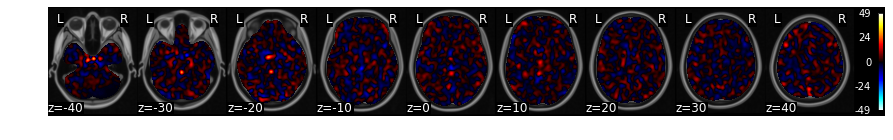

In [113]:
# Smooth Data
smoothed_4 = stats['beta'].smooth(fwhm=4)[0:10]
smoothed_8 = stats['beta'].smooth(fwhm=8)[0:10]


c1 = [0, 1/4, 1/4, 1/4, 1/4, -1/4, -1/4, -1/4, -1/4, 0]
s4_motor_v_cognition = smoothed_4*c1
s8_motor_v_cognition = smoothed_8*c1

s4_v_s8 = s4_motor_v_cognition - s8_motor_v_cognition

# Create Plot
f = s4_v_s8.plot()

# Write to Folder
contrast_name = 's4_v_s8_motor_v_cognition'
visual_v_auditory.write(os.path.join(output_dir, homework_name, f'{sub}_{contrast_name}.nii.gz'))


# 11 Group Analysis

To solve this homework we will first create a folder for the homework. Then we will run the regression to estimate a betas for each condition, looping over all subjects. We will write out each beta in case we want to use them again for anything. I already ran this for each subject and saved them as separate files, but I think it is helpful to see how to run a full analysis on your own.

In [126]:
# Make Output Folder
homework_name = '11_Group_Analysis'
os.mkdir(os.path.join(output_dir, homework_name))

In [127]:
def make_motion_covariates(mc):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

# Get List of Subjects
file_names = glob.glob(os.path.join(data_dir, 'S*'))
sub_list = [os.path.basename(x) for x in file_names]
sub_list.sort()

for sub in sub_list:
    file_name = os.path.join(data_dir, sub ,'preprocessed_fMRI_bold.nii.gz')
    data = Brain_Data(file_name)

    # Build Design Matrix
    tr = 2.4
    df = pd.read_csv(os.path.join(data_dir, 'Design_Matrix.csv'))
    dm = Design_Matrix(df, sampling_freq=1/tr)
    dm_conv = dm.convolve()
    dm_conv_filt = dm_conv.add_dct_basis(duration=128)
    dm_conv_filt_poly = dm_conv_filt.add_poly(order=2, include_lower=True)
    mc = pd.read_csv(os.path.join(data_dir, sub ,'realignment_parameters.txt'), sep='\s', header=None)
    mc_cov = make_motion_covariates(mc)
    spikes = data.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)
    dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, mc_cov, spikes.drop('TR', axis=1)], axis=1)

    # Run Regression (some subjects have a different number of TRs so we will just lop off the end in those cases)
    data.X = dm_conv_filt_poly_cov.iloc[0:data.shape()[0],:]
    stats = data.regress()

    # Extract Only the Task Related Betas (1st 10 regressors)
    betas = stats['beta'][0:df.shape[1]]

    # Smooth Data
    betas = betas.smooth(fwhm=6)

    # Write betas to file
    betas.write(os.path.join(output_dir, homework_name, f'{sub}_localizer_betas.nii.gz'))

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/ipykernel_launcher.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:970: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(np.linalg.pinv(np.dot(X.T, X))))[:, np.newaxis] * sigma[np.newaxis, :]
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/sc

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/Users/lukechang/anaconda3/envs/Psych60_py

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/ipykernel_launcher.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:970: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(np.linalg.pinv(np.dot(X.T, X))))[:, np.newaxis] * sigma[np.newaxis, :]
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/sc

ValueError: self.X does not match the correct size of self.data

## 1. Which regions are more involved with visual compared to auditory sensory processing?
 - Create a contrast to test this hypothesis
 - run a group level t-test
 - plot the results
 - write the file to your output folder.

In [142]:
# Get List of Subjects
file_list = glob.glob(os.path.join(output_dir, homework_name, 'S*_localizer_betas.nii.gz'))
file_list.sort()

# Contrast Codes Excluding Motor
c1 = [1/4, 0, 0, 0, 0, -1/2, 1/4, -1/2, 1/4, 1/4]

# Load All subjects betas and create contrast
visual_v_auditory = []
for f in file_list:
    betas = Brain_Data(f)
    visual_v_auditory.append(betas*c1)
visual_v_auditory = Brain_Data(visual_v_auditory)

# Run T-Test
stats = visual_v_auditory.ttest()
stats['t'].write(os.path.join(output_dir, homework_name, f'Group_t_{contrast_name}_unthresholded.nii.gz'))

# Create Plot
stats['t'].iplot()

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

## 2. Which regions are more involved in processing numbers compared to words?
 - Create a contrast to test this hypothesis
 - run a group level t-test
 - plot the results
 - write the file to your output folder.

In [145]:
# Get List of Subjects
file_list = glob.glob(os.path.join(output_dir, homework_name, 'S*_localizer_betas.nii.gz'))
file_list.sort()

# Contrast Codes 
contrast_name = 'numbers_v_words'
c1 = [0, 0, 0, 0, 0, -1/2, -1/2, 1/2, 1/2, 0]

# Load All subjects betas and create contrast
numbers_v_words = []
for f in file_list:
    betas = Brain_Data(f)
    numbers_v_words.append(betas*c1)
numbers_v_words = Brain_Data(numbers_v_words)

# Run T-Test
stats = numbers_v_words.ttest()
stats['t'].write(os.path.join(output_dir, homework_name, f'Group_t_{contrast_name}_unthresholded.nii.gz'))

# Create Plot
stats['t'].iplot()

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

## 3. Show that a one-sample ttest of differences of betas is equivalent to a two-sample paired t-ttest using any contrast

 - Create contrasts to test this hypothesis
 - run group level tests
 - show that the tests are equivalent numerically
 - plot both of the results


We are ignoring this problem for now.

## 4. Are there gender differences? 
In this exercise, create a two sample design matrix comparing men and women on arithmetic vs reading.

You will first have to figure out the subjects gender using the using the `metadata.csv` file.

 - Create a contrast to test this hypothesis
 - run a group level t-test
 - plot the results
 - write the file to your output folder.

To solve this, you can just use the data we loaded for the previous problem.

Since we know the betas for each subject are already sorted, all we need to do is find the subject Ids of the male and female subjects to create a design matrix for the two-sample t-test.

In [158]:
# Find the sub_ids for the males subject and female subjects
sub_list = [x for x in sub_list if x != 'S30'] # Missing subject 30 data.
meta_data = pd.read_csv(os.path.join(data_dir, 'metadata.csv'), index_col=0)

male_id = list(meta_data['"subject_id"'][meta_data['"gender"']=='male'])
female_id = list(meta_data['"subject_id"'][meta_data['"gender"']=='female'])
male_list = list(set(male_id) & set(sub_list))
female_list = list(set(female_id) & set(sub_list))

# Now reorder the images so that males and females are grouped together
males = numbers_v_words[np.isin(sub_list, male_list)]
females = numbers_v_words[np.isin(sub_list, female_list)]

dat = Brain_Data([males, females])

# Create a design matrix with a two sample t-test comparing females to males using dummy codes
X = np.ones(len(file_list))
X[0:len(male_list)] = -1
dm = pd.DataFrame({'Intercept':np.ones(len(file_list)), 'Female_V_Male':X})

dat.X = dm

stats = dat.regress()

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


Because we used dummy codes there will be two t-test maps.  The first is the intercept, which corresponds to the mean of the reference group, which are the male brains.

In [162]:
stats['t'][0].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

The second image is the difference between the female and male brains on this contrast.

In [164]:
stats['t'][1].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

# 13 Connectivity
To complete these exercises, let's create a folder in our students_output folder.  Then let's denoise all of the data by looping over all subjects and regressing out the covariates. This will save us time in all of the group analyses. This analysis will take awhile to run (at least 30min), so feel free to only run 10-15 participants to save time. Or use the ones I created.

In [165]:
# Make Output Folder
homework_name = '13_Connectivity'
os.mkdir(os.path.join(output_dir, homework_name))

In [166]:
def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

mask = Brain_Data(os.path.join(base_dir, 'resources', 'masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

csf_mask = Brain_Data(os.path.join(base_dir, 'resources', 'masks', 'csf.nii.gz'))
csf = zscore(pd.DataFrame(data.extract_roi(mask=csf_mask).T, columns=['csf']))

tr = 2.4
fwhm = 6
for sub in sub_list:
    file_name = os.path.join(data_dir, sub ,'preprocessed_fMRI_bold.nii.gz')
    data = Brain_Data(file_name)
    n_tr = len(data)
    spikes = data.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)
    mc = pd.read_csv(os.path.join(data_dir, sub ,'realignment_parameters.txt'), sep='\s', header=None)
    mc_cov = make_motion_covariates(mc, tr)
    dm = Design_Matrix(pd.concat([csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
    dm = dm.add_poly(order=2, include_lower=True)

    # Run Regression (some subjects have a different number of TRs so we will just lop off the end in those cases)
    data.X = dm.iloc[0:data.shape()[0],:]
    stats = data.regress()
    smoothed_denoised = stats['residual'].smooth(fwhm=fwhm)
    smoothed_denoised.write(os.path.join(output_dir, homework_name, f'{sub}_smoothed_denoised.nii.gz'))

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:970: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(np.linalg.pinv(np.dot(X.T, X))))[:, np.newaxis] * sigma[np.newaxis, :]
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/sc

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/Users/lukechang/anaconda3/envs/Psych60_py

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:970: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(np.linalg.pinv(np.dot(X.T, X))))[:, np.newaxis] * sigma[np.newaxis, :]
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/sc

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/Users/lukechang/anaconda3/envs/Psych60_py

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:970: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(np.linalg.pinv(np.dot(X.T, X))))[:, np.newaxis] * sigma[np.newaxis, :]
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/sc

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/Users/lukechang/anaconda3/envs/Psych60_py

## 1. Let's calculate seed-based functional connectivity using a different ROI - the right motor cortex

- Calculate functional connectivity using roi=48 with the whole brain.

Now let's extract our seed and run the regression for each subject.

In [179]:
mask = Brain_Data(os.path.join(base_dir, 'resources', 'masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

roi = 48
connectivity = []
sub = 'S01'
sub_dat = Brain_Data(os.path.join(output_dir, homework_name, f'{sub}_smoothed_denoised.nii.gz'))
seed = zscore(pd.DataFrame(sub_dat.extract_roi(mask=mask_x[roi])))
sub_dat.X = seed
sub_stats = sub_dat.regress()

sub_stats['beta'].iplot()

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

## 2. Calculate a group level analysis for this connectivity analysis
- this will require running this analysis over all subjects
- then running a one sample t-test
- then correcting for multiple tests with fdr.

In [171]:
mask = Brain_Data(os.path.join(base_dir, 'resources', 'masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

roi = 48
connectivity = []
for sub in sub_list:
    sub_dat = Brain_Data(os.path.join(output_dir, homework_name, f'{sub}_smoothed_denoised.nii.gz'))
    seed = zscore(pd.DataFrame(sub_dat.extract_roi(mask=mask_x[roi])))
    sub_dat.X = seed
    sub_stats = sub_dat.regress()
    connectivity.append(sub_stats['beta'])
connectivity = Brain_Data(connectivity)

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


TypeError: ttest() got an unexpected keyword argument 'thresh_dict'

In [178]:
group_stats = connectivity.ttest(threshold_dict = {'fdr':.0001})

group_stats['thr_t'].iplot()

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:118: RuntimeWarning: invalid value encountered in less_equal
  below = np.where(s <= null)[0]
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:171: RuntimeWarning: invalid value encountered in less
  mask.data = (mask.data < thr).astype(int)


interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

## 3. Calculate an ICA
- run an ICA analysis for subject01 with 5 components
- plot each spatial component and its associated timecourse

In [182]:
def plot_decomposition_output(stats_output, component):
    '''Generate plots from decompose output'''
    f,a = plt.subplots(nrows=2, figsize = (20,8))
    plot_stat_map(stats_output['components'][component].to_nifti(), 
                  cut_coords=range(-40, 50, 10), display_mode='z',
                  black_bg=True, colorbar=True, draw_cross=False, axes=a[0])
    a[1].plot(stats_output['weights'][:, component], linewidth=3)
    a[1].set_xlabel('Time (TRs)', fontsize=18)
    a[1].set_ylabel('Intensity', fontsize=18)
    a[0].set_title(f'Component: {component}', fontsize=20)
    plt.tight_layout()

sub = 'S01'
n_components = 5
smoothed_denoised = Brain_Data(os.path.join(output_dir, homework_name, f'{sub}_smoothed_denoised.nii.gz'))
ica_stats_output = smoothed_denoised.decompose(algorithm='ica', axis='images', n_components=n_components)

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are no

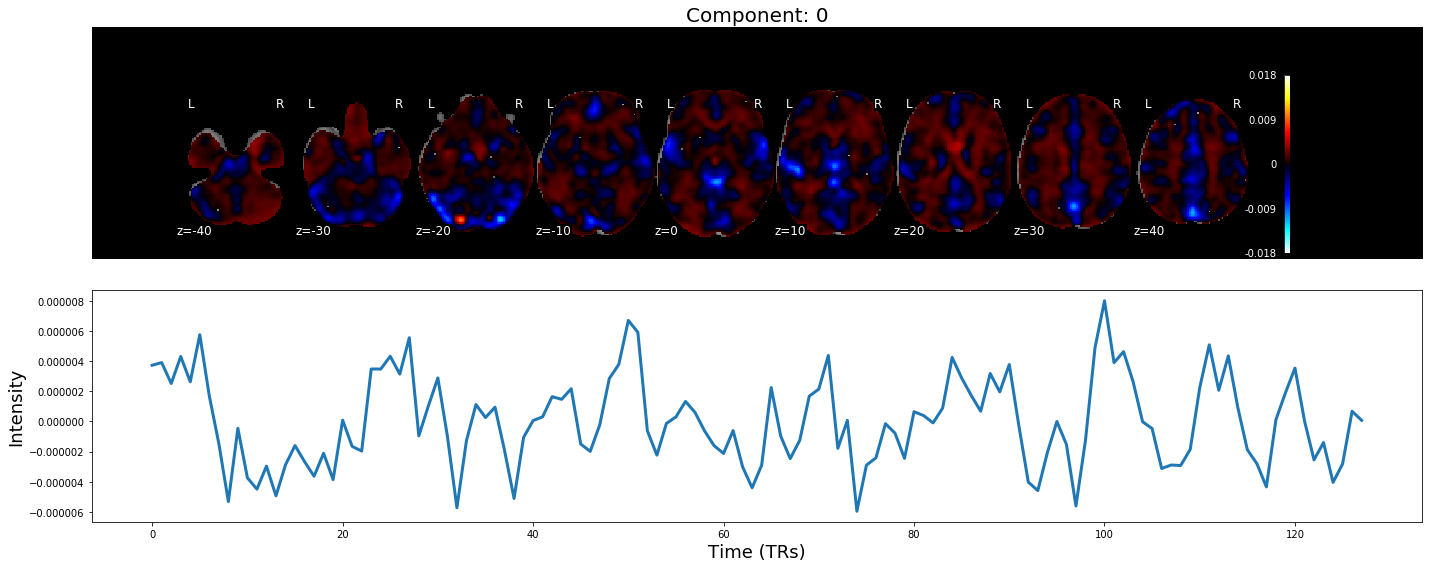

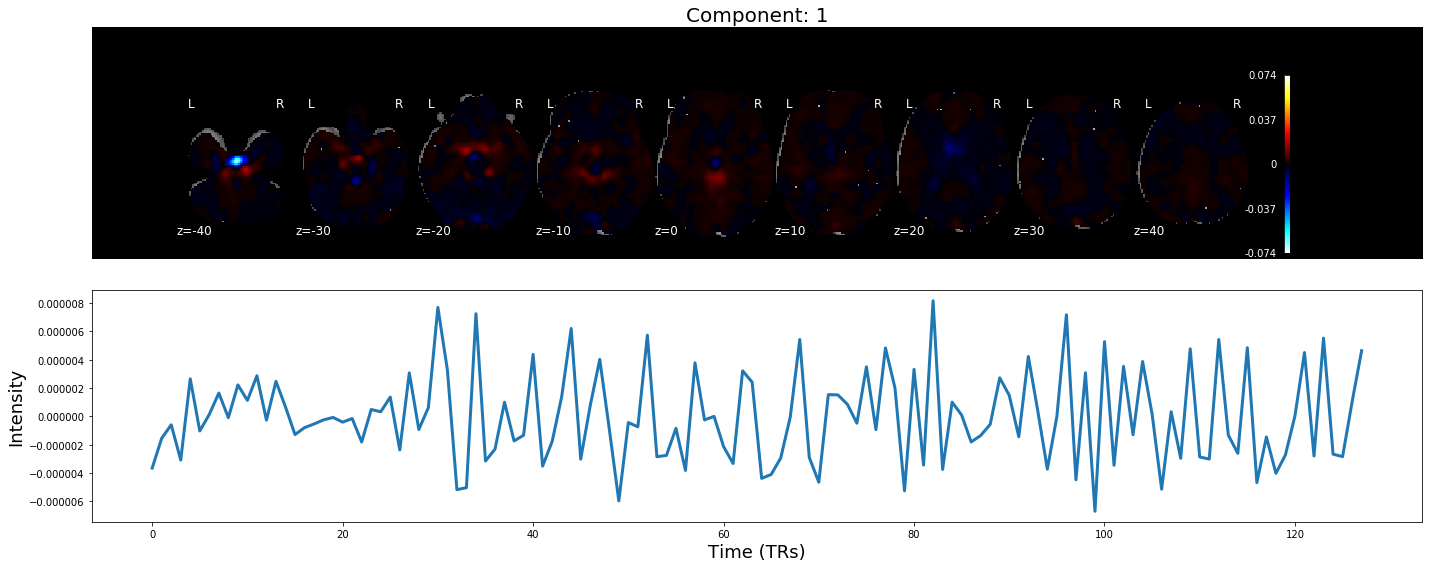

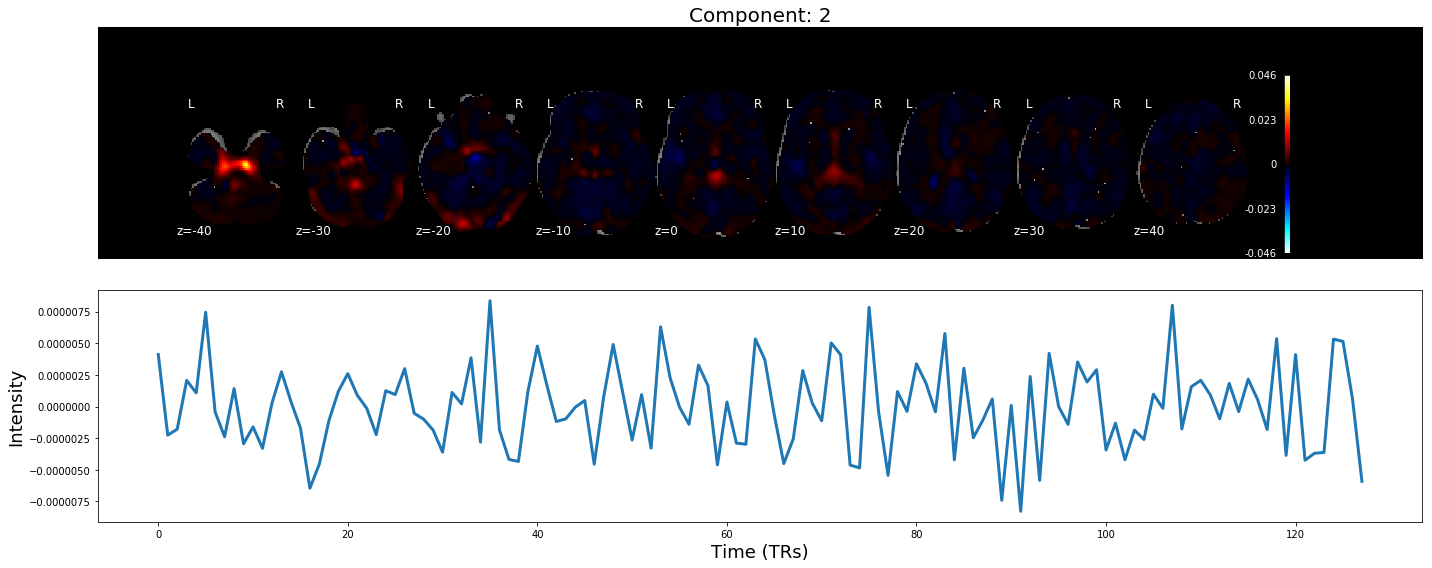

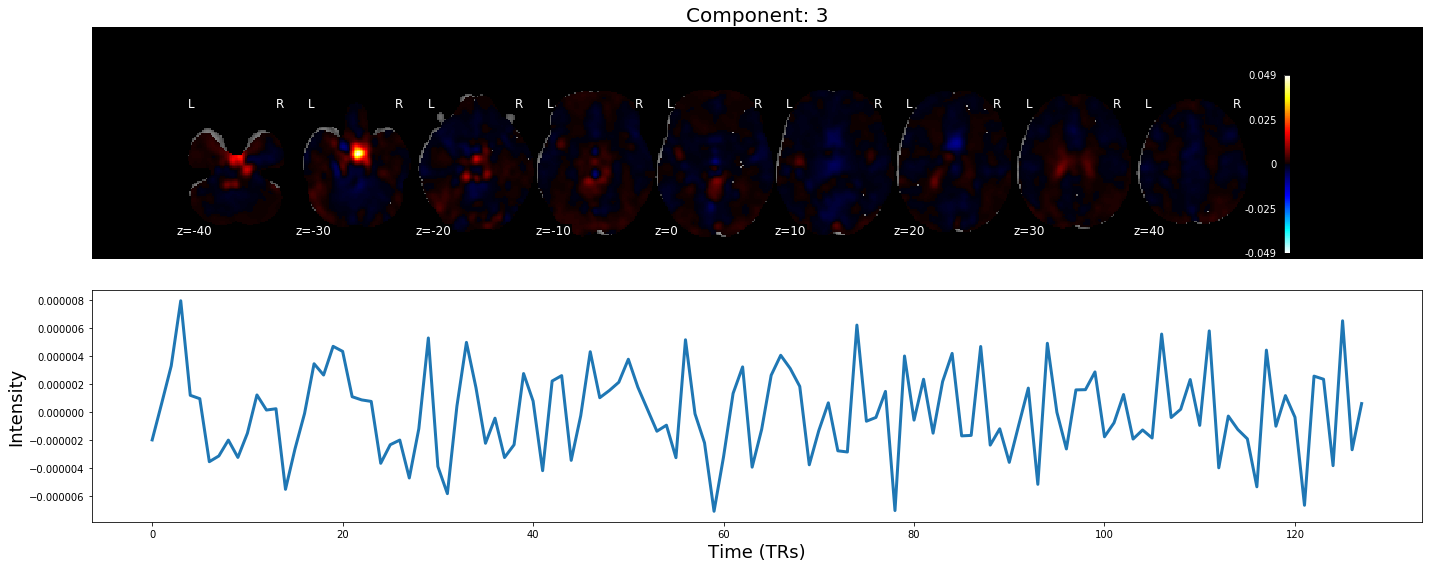

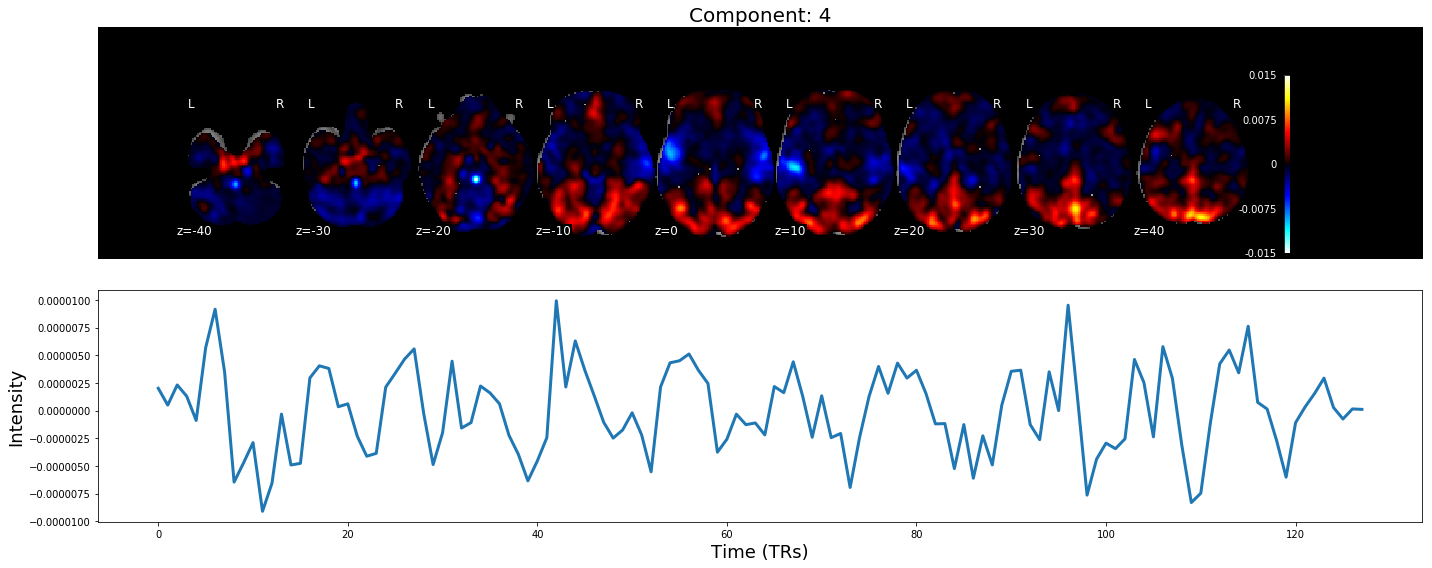

In [184]:
for i in range(n_components):
    plot_decomposition_output(ica_stats_output, i)

## 4. Calculate Eigenvector Centrality for each Region
- figure out how to calculate eigenvector centrality and compute it for each region.

threshold is ignored for simple axial plots


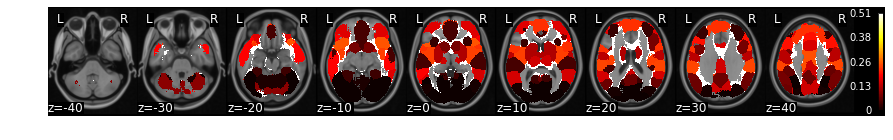

In [188]:
rois = smoothed_denoised.extract_roi(mask=mask)
roi_corr = 1 - pairwise_distances(rois, metric='correlation')
a = Adjacency(roi_corr, matrix_type='similarity')
a_thresholded = a.threshold(upper=.8, binarize=True)
g = a_thresholded.to_graph()
evc = nx.eigenvector_centrality(g)

evc = pd.Series(evc)
evc = Brain_Data([mask_x[x]*float(evc[x]) for x in evc.keys()]).sum()
f = evc.plot()

## 5. Calculate a group level analysis for this graph theoretic analysis
- this will require running this analysis over all subjects
- then running a one sample t-test
- then correcting for multiple tests with fdr.

In [189]:
mask = Brain_Data(os.path.join(base_dir, 'resources', 'masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

centrality = []
for sub in sub_list:
    sub_dat = Brain_Data(os.path.join(output_dir, homework_name, f'{sub}_smoothed_denoised.nii.gz'))
    rois = smoothed_denoised.extract_roi(mask=mask)
    roi_corr = 1 - pairwise_distances(rois, metric='correlation')
    a = Adjacency(roi_corr, matrix_type='similarity')
    a_thresholded = a.threshold(upper=.8, binarize=True)
    g = a_thresholded.to_graph()
    evc = nx.eigenvector_centrality(g)
    evc = pd.Series(evc)
    evc = Brain_Data([mask_x[x]*float(evc[x]) for x in evc.keys()]).sum()
    centrality.append(evc)
centrality = Brain_Data(centrality)

In [193]:
group_stats = centrality.ttest(threshold_dict={'fdr':.001})
group_stats['t'].iplot()

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/nltools/stats.py:118: RuntimeWarning: invalid value encountered in less_equal
  below = np.where(s <= null)[0]


interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…